# 11. Time Series Fundamentals

## What we're going to cover

* Downloading and formatting time series data (the historical price of Bitcoin)
* Writing a preprocessing function to prepare our time series data
* Setting up multiple time series modelling experiments
* Building a multivariate model to take in multivariate time series data
* Replicating the N-Beats algorithm using TensorFlow
* Making forecasts with prediction intervals
* Demonstrating why time series forecasting can be BS with the turkey problem

## Time series inputs and outputs

What will the price of Bitcoin be tomorrow? -> Actual Output<br>
[batch_size, window_size] -> [horizon]

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [1]:
!curl "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" --output "Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  174k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  174k  100  174k    0     0   229k      0 --:--:-- --:--:-- --:--:--  229k


## Importing time series with pandas

In [1]:
import pandas as pd

# Lets read in the Bitcoin data and parse the dates
df = pd.read_csv('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=["Date"], index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can mean thousands to tens of thousands to millions).

A smaller number of samples is typically what you'll run into with time series data problems.

**Note:** The seasonality of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 265 because we collect one sample per day meaning we'll get 365 samples per year.

## Types of Time Series Data

* Trend: time series has a clear long-term increase or decrease (may or may not be linear)
* Seasonal: time series affected by seasonal factors such as time of year (eg increased sales towards the end of the year) or day of week
* Cyclic: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

In [3]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


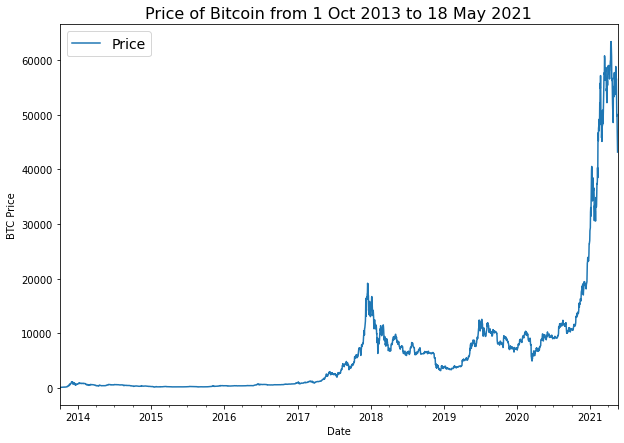

In [4]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize = (10, 7));
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);
plt.legend(fontsize = 14);

In [5]:
import csv
from datetime import datetime

date_list = []
price_list = []
with open('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter= ",")
    next(csv_reader) # skip first line
    for line in csv_reader:
        date_list.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as datetime objects
        price_list.append(float(line[2])) # get the closing price as float

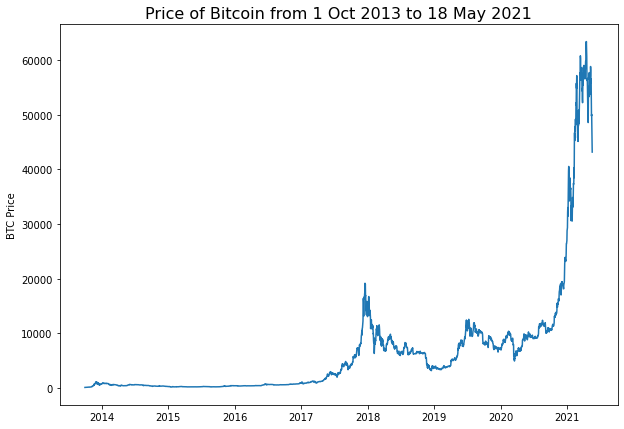

In [6]:
import numpy as np

plt.figure(figsize = (10, 7));
plt.plot(date_list, price_list);
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [7]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [8]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

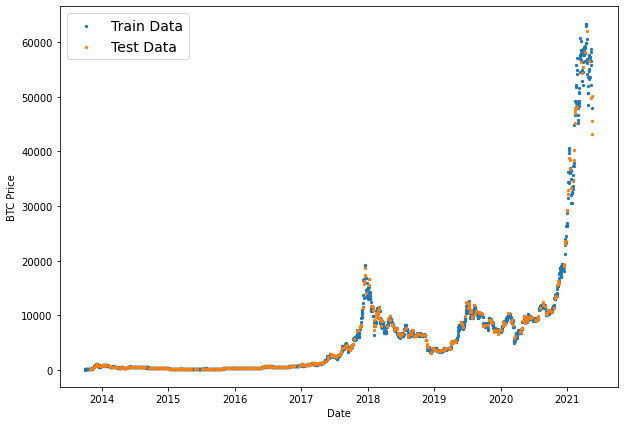

In [9]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

## Create train and test sets for time series (the right way)

In [10]:
# create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

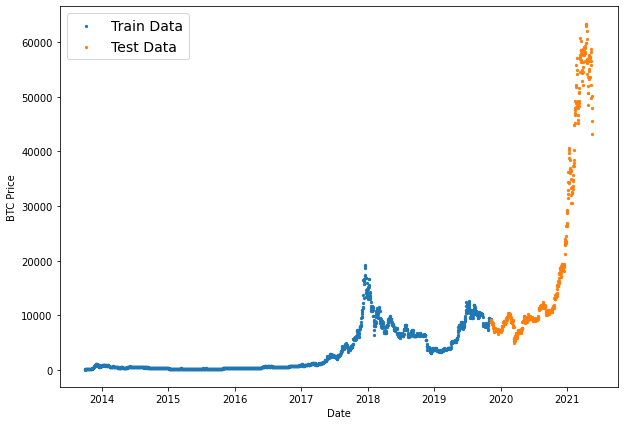

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

In [12]:
### Create a plotting function
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps)
    Parameters
    ---------
    timesteps : array of timesteps values
    values : array of values across time
    format : style of plot, default '.'
    start : where to start the plot (setting a value will index from start of timesteps)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

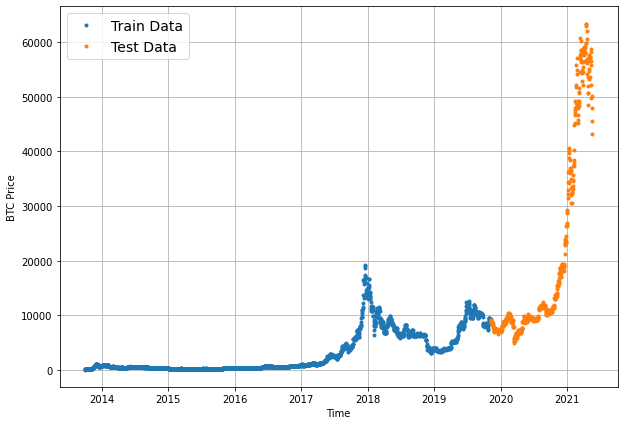

In [13]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps=X_train, values = y_train, label = "Train Data")
plot_time_series(timesteps=X_test, values = y_test, label = "Test Data")

## Modelling Experiments

* **Horizon** : number of timesteps into the future we're going to predict
* **Window size** : number of timesteps we're going to use to predict **horizon**

|Experiment|Model|horizon|window|
|----------|-----|-------|------|
|0|Naive model (baseline)|||
|1|Dense model|1|7|
|2|Same as model 1|1|30|
|3|Same as model 1|7|30|
|4|Conv1D|1|7|
|5|LSTM|1|7|
|6|Same as model 1 (but with multivariate data|1|7|
|7|N-BEATS algorithm|1|7|
|8|Ensemble (multiple models stacked together|1|7|
|9|Future Prediction model|1|7|
|10|Same as model 1 (but with turkey data introduced|1|7|

## Model 0: Naive Model (Baseline)

The formula looks like this:

$$\hat{y}(t) = y(t - 1)$$

In english:
> The prediction at timestep "t" is equal to the value at timestep "t-1"

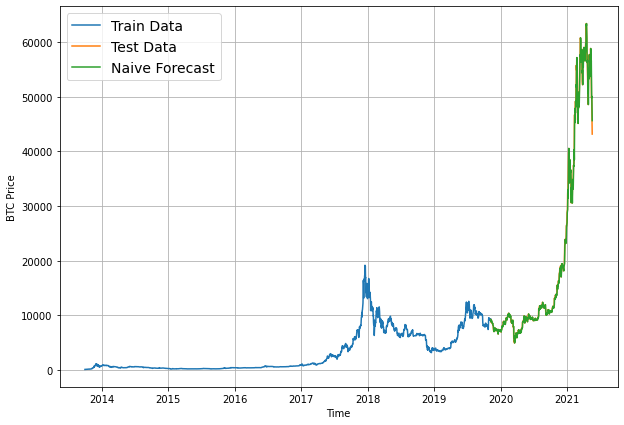

In [17]:
# Plot naive forecast
naive_forecast = y_test[:-1]

plt.figure(figsize = (10, 7))
plot_time_series(X_train, y_train, label = "Train Data", format = "-")
plot_time_series(X_test, y_test, label = "Test Data", format="-")
plot_time_series(X_test[1:], naive_forecast, label = "Naive Forecast", format="-")

## Evaluating a time series model

Let's look into some evaluation metrics for time-series

What are we doing?

We're predicting a number, so that means we have a form of regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

|Metric Name|Metric Formula|Tensorflow code|When to use|
|-----------|--------------|---------------|-----------|
|Mean absolute error (MAE)|$MAE = \frac{\sum_{i=1}^{n}abs(y_i - x_i)}{n}$|tf.keras.losses.MAE() or tf.keras.losses.mean_absolute_error()|As a great starter metric for any regression problem.|
|Mean square error (MSE)|$MSE = \frac{\sum_{i=1}^{n}abs(Y_i - \hat{Y_i})^2}{n}$|tf.keras.losses.MSE() or tf.keras.losses.mean_square_error()|When larger errors are more significant than smaller errors.|
|Root mean squared error (RMSE)|$RMSE = \sqrt{MSE}$|tf.sqrt(tf.metrics.mean_square_error())|Similar to MSE but as interpretable as MAE (RMSE is in same units are target)|
|(Scaled) Mean absolute percentage error (MAPE/sMAPE)|$MAPE = mean(abs(100e_t/y_t))$|tf.keras.metrics.mean_absolute_percentage_error()|Recommend not to use by Hyndman and Koehler|
|Mean absolute scaled error (MASE)|$q_j = \frac{e_j}{\frac{1}{T-1}\sum_{t=2}^{T}abs(y_t-y_{t-1})}$|Custom or See sktime's mase_loss()|A scaled error is > 1 if the forecast is worse than the naive and <1 if the forecast is better than the naive|

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

In [19]:
import tensorflow as tf

In [15]:
# MASE implementation

def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data)
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[1:])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [20]:
mean_absolute_scaled_error(y_true = y_test[1:], y_pred = naive_forecast).numpy()

0.9995699939182624

In [21]:
# Create a function to take in model predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae":mae.numpy(), "mse": mse.numpy(), "rmse": rmse.numpy(), "mape":mape.numpy(), "mase": mase.numpy()}

That's one good looking evaluation function!

Lets now see if it works

In [22]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models you may want to experiment with:
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Window our dataset

Why do we window?

We window our dataset to convert our data into a supervised learning problem

Windowing for one week

[0,1,2,3,4,5,6] -> [7]<br>
[1,2,3,4,5,6,7] -> [8]<br>
[2,3,4,5,6,7,8] -> [9]

In [23]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_windows(x, horizon = HORIZON):
    """
    Creates labels for windowed dataset.

    Eg if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6] -> Output: [0,1,2,3,4,5,6] -> [7] 
    """
    return x[:,:-horizon], x[:, -horizon:]

In [28]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis = 0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]])>)

We've got a way to label our windowed data.

However it only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops but that would be quite slow for large time series

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (eg [0,1,2,3,4,5,6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[
    [0,1,2,3,4,5,6],
    [1,2,3,4,5,6,7],
    [2,3,4,5,6,7,8]
    ....
]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (eg. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [24]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of a window size with horizon size labels.
    """
    # 1. Create a window of specified window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 1)

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon = horizon)

    return windows, labels

In [42]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [43]:
# View the first 3 windows/labels
for i in range(3):
    print(f'Window: {full_windows[i]} -> Label: {full_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


Alternatively, we can use `tf.keras.preprocessing.timeseries_dataset_from_array()` to the same effect.

## Turning windows into training and test sets

In [25]:
# Make the train/test splits

def make_train_test_splits(windows, labels, test_split = 0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [46]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [47]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [50]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[: -HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling Checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [26]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "Checkpoint/Time_Series"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose = 0,
                                              save_best_only = True)

## Model 1: Dense Model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128  (previously we've used 32)
* 100 epochs

Why these values?

Picked with experimentation.

In [53]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = 'relu', name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer") # linear activation is the same as having no activation.
    ], name = "model_1_dense"
)

# Compile the model
model_1.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_1 = model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs = 100,
    verbose = 1,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_name = model_1.name)]
)

Epoch 1/100
18/18 [==============================] - 4s 72ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 56ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.2188 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 51ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
Epoch 4/100
18/18 [==============================] - 1s 46ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5871 - val_mae: 900.5871 - val_mse: 2683715.0000
Epoch 5/100
18/18 [==============================] - 1s 52ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.0000
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 158.5

In [54]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 12ms/step - loss: 585.9755 - mae: 585.9755 - mse: 1197802.0000


[585.9755249023438, 585.9755249023438, 1197802.0]

In [55]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('Checkpoint/Time_Series/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 14ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.7500


[568.9509887695312, 568.9509887695312, 1171743.75]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future). Let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [18]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [62]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 7ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.712, 8769.886, 9015.712, 8795.519, 8723.811, 8730.112,
        8691.953, 8502.054, 8460.96 , 8516.548], dtype=float32)>)

In [63]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 1.0}

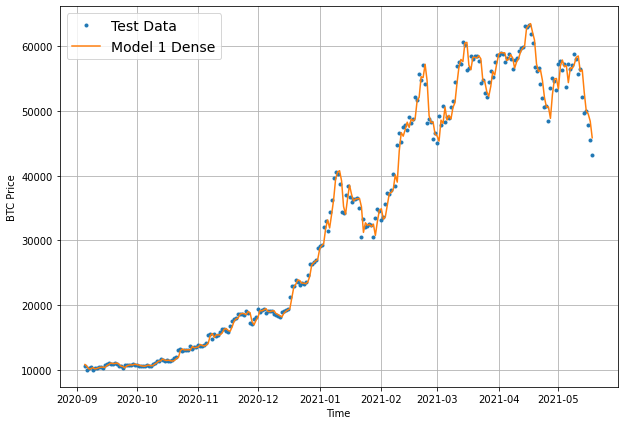

In [70]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows):], model_1_preds, start = offset, label = "Model 1 Dense", format="-")

## Model 2: Dense (window = 30, horizon = 1)

In [72]:
full_windows_30, full_labels_30 = make_windows(prices, window_size = 30, horizon = 1)
full_windows_30.shape, full_labels_30.shape

((2757, 30), (2757, 1))

In [73]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30, 0.2)
train_windows_30.shape, test_windows_30.shape, train_labels_30.shape, test_labels_30.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [74]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = 'relu', name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer") # linear activation is the same as having no activation.
    ], name = "model_2_dense"
)

# Compile the model
model_2.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_2 = model_2.fit(
    x = train_windows_30,
    y = train_labels_30,
    epochs = 100,
    verbose = 0,
    batch_size = 128,
    validation_data = (test_windows_30, test_labels_30),
    callbacks = [create_model_checkpoint(model_name = model_2.name)]
)

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_S

In [75]:
# Evaluate model 3 on test data
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 17ms/step - loss: 665.5611 - mae: 665.5611 - mse: 1431146.3750


[665.5610961914062, 665.5610961914062, 1431146.375]

In [76]:
model_2 = tf.keras.models.load_model('Checkpoint/Time_Series/model_2_dense')
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 14ms/step - loss: 616.3276 - mae: 616.3276 - mse: 1309629.8750


[616.3275756835938, 616.3275756835938, 1309629.875]

In [77]:
model_2_preds = make_preds(model_2, test_windows_30)
model_2_results = evaluate_preds(tf.squeeze(test_labels_30), model_2_preds)
model_2_results

18/18 [==============================] - 0s 5ms/step


{'mae': 616.3275,
 'mse': 1309630.0,
 'rmse': 1144.3907,
 'mape': 2.8121033,
 'mase': 1.0}

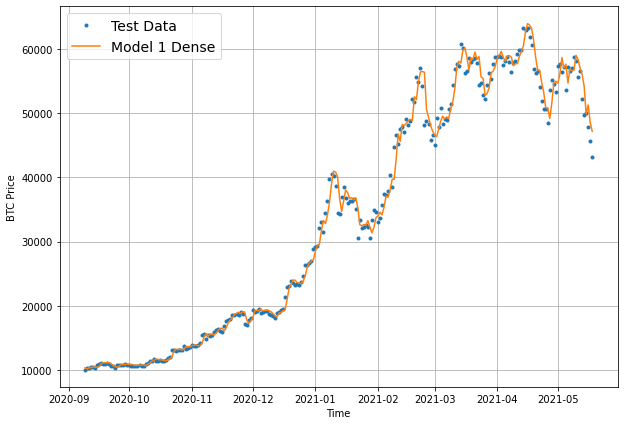

In [79]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows_30):], values = test_labels_30[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows_30):], model_2_preds, start = offset, label = "Model 1 Dense", format="-")

## Model 3: Building, fitting and evaluating a model with a larger horizon size

In [85]:
HORIZON = 7
full_windows_30, full_labels_7 = make_windows(prices, window_size = 30, horizon = HORIZON)
train_windows_30, test_windows_30, train_labels_7, test_labels_7= make_train_test_splits(full_windows_30, full_labels_7, 0.2)

train_dataset_win_30_hor_7 = tf.data.Dataset.from_tensor_slices((train_windows_30, train_labels_7)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset_win_30_hor_7 = tf.data.Dataset.from_tensor_slices((test_windows_30, test_labels_7)).batch(128).prefetch(tf.data.AUTOTUNE)

In [89]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = "relu", name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer")
    ], name = "model_3"
)

# Compile the model
model_3.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_3 = model_3.fit(
    train_dataset_win_30_hor_7,
    epochs = 100,
    steps_per_epoch = len(train_dataset_win_30_hor_7),
    validation_data = test_dataset_win_30_hor_7,
    validation_steps = len(test_dataset_win_30_hor_7),
    callbacks = [create_model_checkpoint(model_3.name)]
)

Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 849.9856 - mae: 849.9856 - mse: 2561418.5000 - val_loss: 2833.7292 - val_mae: 2833.7292 - val_mse: 21220530.0000
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 776.3613 - mae: 776.3613 - mse: 3236622.0000 - val_loss: 2921.7356 - val_mae: 2921.7356 - val_mse: 24942838.0000
Epoch 3/100
18/18 [==============================] - 1s 34ms/step - loss: 568.4208 - mae: 568.4208 - mse: 1409358.3750 - val_loss: 2418.1624 - val_mae: 2418.1624 - val_mse: 16601201.0000
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 577.0087 - mae: 577.0087 - mse: 1590245.5000 - val_loss: 2253.5933 - val_mae: 2253.5933 - val_mse: 14206937.0000
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 580.2460 - mae: 580.2460 - mse: 1477238.0000 - val_loss: 2519.0977 - val_mae: 2519.0977 - val_mse: 17037242.0000
Epoch 6/100
18/18 [==============================] - 1s 31ms/step -

In [90]:
# Evaluate model 3 on test data
model_3.evaluate(test_dataset_win_30_hor_7)

5/5 [==============================] - 0s 9ms/step - loss: 1532.5125 - mae: 1532.5125 - mse: 7043627.0000


[1532.512451171875, 1532.512451171875, 7043627.0]

In [91]:
# Load in best model and evaluate
model_3 = tf.keras.models.load_model('Checkpoint/Time_Series/model_3')
model_3.evaluate(test_dataset_win_30_hor_7)

5/5 [==============================] - 0s 6ms/step - loss: 1467.0591 - mae: 1467.0591 - mse: 6728659.5000


[1467.05908203125, 1467.05908203125, 6728659.5]

In [100]:
model_3_preds = make_preds(model_3, test_dataset_win_30_hor_7)
model_3_results = evaluate_preds(tf.transpose(tf.squeeze(test_labels_7)), tf.transpose(model_3_preds))
model_3_results

5/5 [==============================] - 0s 6ms/step


{'mae': array([ 810.67  , 1335.675 , 1261.8787, 1679.6757, 1620.7969, 1695.685 ,
        1865.0322], dtype=float32),
 'mse': array([ 2006908. ,  4707959. ,  4827960. ,  7741320. ,  7849688.5,
         8940066. , 11026715. ], dtype=float32),
 'rmse': array([1416.6538, 2169.7832, 2197.262 , 2782.3228, 2801.7295, 2989.9944,
        3320.6497], dtype=float32),
 'mape': array([3.8086734, 6.352503 , 5.7951255, 7.6418533, 7.277156 , 7.651893 ,
        8.184331 ], dtype=float32),
 'mase': 1.0}

## Make our evaluation function work for larger horizons

In [101]:
model_3_results["mae"].shape

(7,)

In [27]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae":mae.numpy(), "mse": mse.numpy(), "rmse": rmse.numpy(), "mape":mape.numpy(), "mase": mase.numpy()}

In [103]:
model_3_results = evaluate_preds(tf.transpose(tf.squeeze(test_labels_7)), tf.transpose(model_3_preds))
model_3_results

{'mae': 1467.0592,
 'mse': 6728659.5,
 'rmse': 2525.4849,
 'mape': 6.6730766,
 'mase': 1.0}

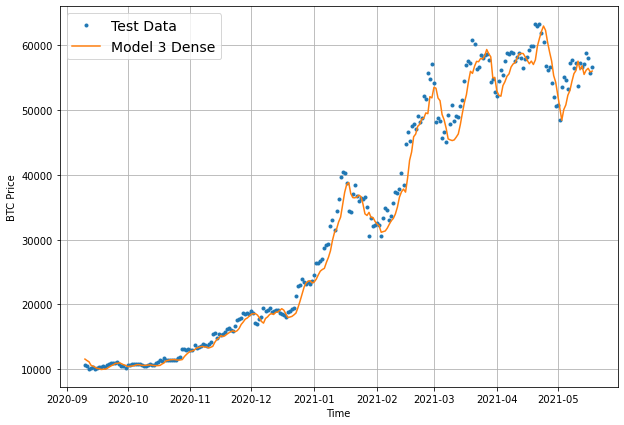

In [115]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows_30):], values = test_labels_7[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows_30):], tf.reduce_mean(model_3_preds, axis = 1), start = offset, label = "Model 3 Dense", format="-")

## Comparing our models so far

In [120]:
import pandas as pd
all_results = pd.DataFrame({"model_0_naive": naive_results, "model_1_hor_1_win_7": model_1_results, "model_2_hor_1_win_30": model_2_results, "model_3_hor_7_win_7": model_3_results})
all_results = all_results.transpose()
all_results

,mae,mse,rmse,mape,mase
model_0_naive,567.980225,1147547.00,1071.236206,2.516525,1.0
model_1_hor_1_win_7,568.951050,1171743.75,1082.471069,2.544898,1.0
model_2_hor_1_win_30,616.327515,1309630.00,1144.390747,2.812103,1.0
model_3_hor_7_win_7,1467.059204,6728659.50,2525.484863,6.673077,1.0


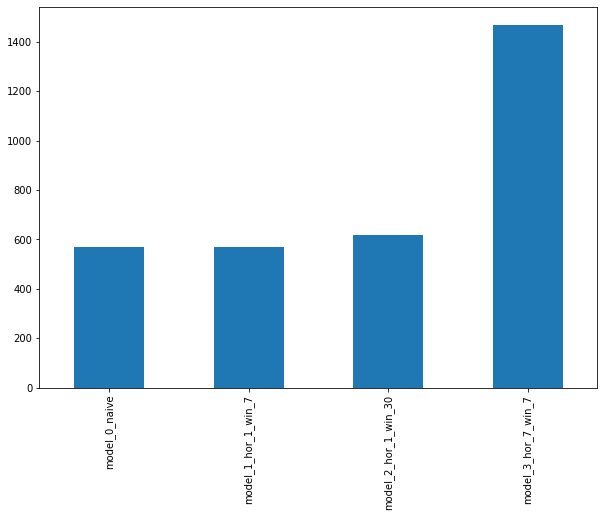

In [121]:
all_results["mae"].plot(figsize = (10, 7), kind = "bar");

Why are the naive results so good? One of the reasons could be the presence of autocorrelation in the data. If a time series has autocorrelation, it means the value at `t+1` is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to the value at yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

## Model 4: Conv1D

In [123]:
HORIZON = 1
WINDOW_SIZE = 7

In [125]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [126]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, 0.2)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [127]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_windows, train_labels)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_windows, test_labels)).batch(128).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

To use the Conv1D layer, we need an input shape of: (batch_size, timesteps, input_dim)
However, our data isn't in that shape yet.

In [129]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 2))
x=tf.random.normal(shape = (128, 7,))
print(f'Original shape: {x.shape}')
print(f'New shape: {expand_dims_layer(x).shape}')

Original shape: (128, 7)
New shape: (128, 7, 1)


In [168]:
# Create model
model_4 = tf.keras.Sequential(
    [
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1), name = "expand_dimensions_layer"),
        tf.keras.layers.Conv1D(128, 5, activation = "relu", padding = 'causal', name = "conv_layer"),
        tf.keras.layers.Dense(HORIZON, activation = "linear", name  = "output_layer")
    ], name = "model_4_conv"
)

# Compile the model
model_4.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.losses.MAE, tf.keras.losses.MSE]
)

# Fit the model
history_model_4 = model_4.fit(
    x = train_windows,
    y = train_labels,
    batch_size = 128,
    epochs = 100,
    validation_data = (test_windows, test_labels),
    verbose = 0,
    callbacks = [create_model_checkpoint(model_4.name)]
)

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_4_conv\assets


In [169]:
model_4.summary()

Model: "model_4_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 expand_dimensions_layer (La  (None, 1, 7)             0         
 mbda)                                                           
                                                                 
 conv_layer (Conv1D)         (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [180]:
# Evaluate the model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 10ms/step - loss: 584.7285 - mean_absolute_error: 584.7285 - mean_squared_error: 1219352.8750


[584.728515625, 584.728515625, 1219352.875]

In [181]:
model_4 = tf.keras.models.load_model('Checkpoint/Time_Series/model_4_conv')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 584.7285 - mean_absolute_error: 584.7285 - mean_squared_error: 1219352.8750


[584.728515625, 584.728515625, 1219352.875]

In [172]:
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(tf.transpose(tf.squeeze(test_labels)), tf.transpose(model_4_preds))
model_4_results

18/18 [==============================] - 0s 8ms/step


{'mae': 584.7285,
 'mse': 1219352.9,
 'rmse': 1104.243,
 'mape': 2.615557,
 'mase': 1.0}

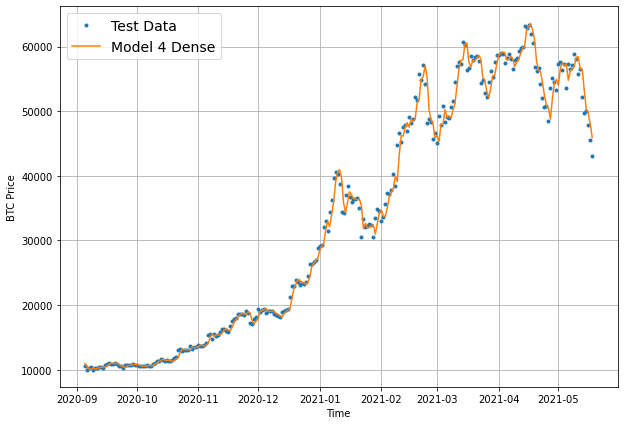

In [173]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows):], model_4_preds, start = offset, label = "Model 4 Dense", format="-")

## Model 5: RNN (LSTM)

In [186]:
tf.random.set_seed(42)

# Create the model
inputs = tf.keras.layers.Input(shape = (WINDOW_SIZE), name = "input_layer")
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1), name = "expand_dims_layer")(inputs)
x = tf.keras.layers.LSTM(128, activation = "relu",name = "lstm_layer")(x)
outputs = tf.keras.layers.Dense(HORIZON, activation = "linear", name = "output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_lstm")

# Compile the model
model_5.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.losses.MAE, tf.keras.losses.MSE]
)

# Fit the model
history_model_5 = model_5.fit(
    x = train_windows,
    y = train_labels,
    epochs = 100,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    verbose = 1,
    callbacks = [create_model_checkpoint(model_5.name)]
)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2323.6082 - mean_absolute_error: 2323.6082 - mean_squared_error: 13451164.0000INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 4s 144ms/step - loss: 2323.6082 - mean_absolute_error: 2323.6082 - mean_squared_error: 13451164.0000 - val_loss: 9222.6523 - val_mean_absolute_error: 9222.6523 - val_mean_squared_error: 150544848.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 741.1183 - mean_absolute_error: 741.1183 - mean_squared_error: 1798469.2500INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 141ms/step - loss: 695.4739 - mean_absolute_error: 695.4739 - mean_squared_error: 1664331.0000 - val_loss: 1486.0555 - val_mean_absolute_error: 1486.0555 - val_mean_squared_error: 6266154.5000
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 246.8830 - mean_absolute_error: 246.8830 - mean_squared_error: 249953.3281INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 137ms/step - loss: 237.3967 - mean_absolute_error: 237.3967 - mean_squared_error: 238510.3281 - val_loss: 1298.9084 - val_mean_absolute_error: 1298.9084 - val_mean_squared_error: 4394857.5000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 182.2439 - mean_absolute_error: 182.2439 - mean_squared_error: 171235.8906INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 137ms/step - loss: 181.9180 - mean_absolute_error: 181.9180 - mean_squared_error: 168791.5625 - val_loss: 966.6430 - val_mean_absolute_error: 966.6430 - val_mean_squared_error: 3159459.0000
Epoch 5/100
18/18 [==============================] - 1s 33ms/step - loss: 173.4022 - mean_absolute_error: 173.4022 - mean_squared_error: 159026.5312 - val_loss: 970.9295 - val_mean_absolute_error: 970.9295 - val_mean_squared_error: 3095508.0000
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 172.5681 - mean_absolute_error: 172.5681 - mean_squared_error: 144768.4688INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 197ms/step - loss: 173.5414 - mean_absolute_error: 173.5414 - mean_squared_error: 154012.8281 - val_loss: 941.4746 - val_mean_absolute_error: 941.4746 - val_mean_squared_error: 2827413.5000
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 176.3560 - mean_absolute_error: 176.3560 - mean_squared_error: 165587.3594INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 141ms/step - loss: 170.3566 - mean_absolute_error: 170.3566 - mean_squared_error: 155902.1562 - val_loss: 898.5215 - val_mean_absolute_error: 898.5215 - val_mean_squared_error: 2614158.7500
Epoch 8/100
18/18 [==============================] - 0s 23ms/step - loss: 157.6712 - mean_absolute_error: 157.6712 - mean_squared_error: 136152.2812 - val_loss: 914.8641 - val_mean_absolute_error: 914.8641 - val_mean_squared_error: 2657904.5000
Epoch 9/100
18/18 [==============================] - 0s 19ms/step - loss: 166.5143 - mean_absolute_error: 166.5143 - mean_squared_error: 146057.1875 - val_loss: 1079.0775 - val_mean_absolute_error: 1079.0775 - val_mean_squared_error: 3372638.0000
Epoch 10/100
15/18 [========================>.....] - ETA: 0s - loss: 158.8814 - mean_absolute_error: 158.8814 - mean_squared_error: 125373.8516INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 126ms/step - loss: 162.3369 - mean_absolute_error: 162.3369 - mean_squared_error: 134529.5625 - val_loss: 877.1689 - val_mean_absolute_error: 877.1689 - val_mean_squared_error: 2416075.5000
Epoch 11/100
18/18 [==============================] - 0s 26ms/step - loss: 163.0841 - mean_absolute_error: 163.0841 - mean_squared_error: 142166.7344 - val_loss: 924.1126 - val_mean_absolute_error: 924.1126 - val_mean_squared_error: 2880439.0000
Epoch 12/100
18/18 [==============================] - 0s 19ms/step - loss: 168.5598 - mean_absolute_error: 168.5598 - mean_squared_error: 149940.1094 - val_loss: 941.6025 - val_mean_absolute_error: 941.6025 - val_mean_squared_error: 2945408.5000
Epoch 13/100
18/18 [==============================] - 0s 18ms/step - loss: 166.4727 - mean_absolute_error: 166.4727 - mean_squared_error: 149715.0000 - val_loss: 934.8435 - val_mean_absolute_error: 934.8436 - val_mean_squared_error: 2894060.2500
Epoch 14/100
18/18 [========

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 129ms/step - loss: 152.9470 - mean_absolute_error: 152.9470 - mean_squared_error: 123160.4453 - val_loss: 856.2653 - val_mean_absolute_error: 856.2653 - val_mean_squared_error: 2465898.7500
Epoch 16/100
18/18 [==============================] - 0s 26ms/step - loss: 147.4420 - mean_absolute_error: 147.4420 - mean_squared_error: 116629.3906 - val_loss: 898.9912 - val_mean_absolute_error: 898.9912 - val_mean_squared_error: 2276295.2500
Epoch 17/100
18/18 [==============================] - 0s 17ms/step - loss: 151.0533 - mean_absolute_error: 151.0533 - mean_squared_error: 118490.4922 - val_loss: 943.1415 - val_mean_absolute_error: 943.1415 - val_mean_squared_error: 2741249.0000
Epoch 18/100
18/18 [==============================] - 0s 17ms/step - loss: 157.8232 - mean_absolute_error: 157.8232 - mean_squared_error: 135940.5000 - val_loss: 924.0045 - val_mean_absolute_error: 924.0045 - val_mean_squared_error: 2666360.5000
Epoch 19/100
18/18 [========

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 134ms/step - loss: 146.8467 - mean_absolute_error: 146.8467 - mean_squared_error: 120590.7266 - val_loss: 845.2780 - val_mean_absolute_error: 845.2780 - val_mean_squared_error: 2279687.7500
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 145.5996 - mean_absolute_error: 145.5996 - mean_squared_error: 111557.4453INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 170ms/step - loss: 145.9843 - mean_absolute_error: 145.9843 - mean_squared_error: 118008.3516 - val_loss: 818.6807 - val_mean_absolute_error: 818.6807 - val_mean_squared_error: 2195707.5000
Epoch 27/100
16/18 [=========================>....] - ETA: 0s - loss: 144.7295 - mean_absolute_error: 144.7295 - mean_squared_error: 115292.5938INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 138ms/step - loss: 144.4289 - mean_absolute_error: 144.4289 - mean_squared_error: 116627.6328 - val_loss: 804.3278 - val_mean_absolute_error: 804.3278 - val_mean_squared_error: 2141244.0000
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 142.4610 - mean_absolute_error: 142.4610 - mean_squared_error: 115313.7891INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 136ms/step - loss: 142.4610 - mean_absolute_error: 142.4610 - mean_squared_error: 115313.7891 - val_loss: 789.0858 - val_mean_absolute_error: 789.0858 - val_mean_squared_error: 2095049.6250
Epoch 29/100
18/18 [==============================] - 0s 28ms/step - loss: 141.8738 - mean_absolute_error: 141.8738 - mean_squared_error: 112794.9219 - val_loss: 806.6756 - val_mean_absolute_error: 806.6756 - val_mean_squared_error: 2090219.2500
Epoch 30/100
18/18 [==============================] - 0s 18ms/step - loss: 142.0521 - mean_absolute_error: 142.0521 - mean_squared_error: 112808.3438 - val_loss: 794.8835 - val_mean_absolute_error: 794.8835 - val_mean_squared_error: 2040775.1250
Epoch 31/100
15/18 [========================>.....] - ETA: 0s - loss: 136.6255 - mean_absolute_error: 136.6255 - mean_squared_error: 108646.5469INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 138ms/step - loss: 138.4690 - mean_absolute_error: 138.4690 - mean_squared_error: 107980.4688 - val_loss: 773.2811 - val_mean_absolute_error: 773.2811 - val_mean_squared_error: 1972856.0000
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 138.0486 - mean_absolute_error: 138.0486 - mean_squared_error: 107628.3594INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 163ms/step - loss: 137.1986 - mean_absolute_error: 137.1986 - mean_squared_error: 106284.4844 - val_loss: 772.2625 - val_mean_absolute_error: 772.2625 - val_mean_squared_error: 1948036.6250
Epoch 33/100
18/18 [==============================] - 1s 33ms/step - loss: 135.9342 - mean_absolute_error: 135.9342 - mean_squared_error: 103751.0312 - val_loss: 786.4801 - val_mean_absolute_error: 786.4801 - val_mean_squared_error: 1961975.7500
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 136.1931 - mean_absolute_error: 136.1931 - mean_squared_error: 104538.6016INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 166ms/step - loss: 136.1931 - mean_absolute_error: 136.1931 - mean_squared_error: 104538.6016 - val_loss: 744.4506 - val_mean_absolute_error: 744.4506 - val_mean_squared_error: 1886289.8750
Epoch 35/100
18/18 [==============================] - 0s 24ms/step - loss: 133.4514 - mean_absolute_error: 133.4514 - mean_squared_error: 102255.6328 - val_loss: 756.2968 - val_mean_absolute_error: 756.2968 - val_mean_squared_error: 1852667.1250
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 134.0992 - mean_absolute_error: 134.0992 - mean_squared_error: 103215.3203INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 194ms/step - loss: 134.0992 - mean_absolute_error: 134.0992 - mean_squared_error: 103215.3203 - val_loss: 735.1729 - val_mean_absolute_error: 735.1729 - val_mean_squared_error: 1840292.1250
Epoch 37/100
18/18 [==============================] - 0s 23ms/step - loss: 130.6932 - mean_absolute_error: 130.6932 - mean_squared_error: 99329.6406 - val_loss: 745.9096 - val_mean_absolute_error: 745.9096 - val_mean_squared_error: 1796193.1250
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 129.2891 - mean_absolute_error: 129.2891 - mean_squared_error: 96651.1719INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 134ms/step - loss: 129.2891 - mean_absolute_error: 129.2891 - mean_squared_error: 96651.1719 - val_loss: 717.2498 - val_mean_absolute_error: 717.2498 - val_mean_squared_error: 1739679.2500
Epoch 39/100
18/18 [==============================] - 1s 30ms/step - loss: 129.6088 - mean_absolute_error: 129.6088 - mean_squared_error: 97402.8438 - val_loss: 719.0669 - val_mean_absolute_error: 719.0669 - val_mean_squared_error: 1764966.1250
Epoch 40/100
18/18 [==============================] - 0s 21ms/step - loss: 129.6111 - mean_absolute_error: 129.6111 - mean_squared_error: 96268.3359 - val_loss: 732.0630 - val_mean_absolute_error: 732.0630 - val_mean_squared_error: 1722417.7500
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 128.0795 - mean_absolute_error: 128.0795 - mean_squared_error: 95287.3516 INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 154ms/step - loss: 127.1393 - mean_absolute_error: 127.1393 - mean_squared_error: 94059.6328 - val_loss: 702.9354 - val_mean_absolute_error: 702.9354 - val_mean_squared_error: 1654539.2500
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 125.6113 - mean_absolute_error: 125.6113 - mean_squared_error: 93062.1250INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 161ms/step - loss: 125.6113 - mean_absolute_error: 125.6113 - mean_squared_error: 93062.1250 - val_loss: 700.8699 - val_mean_absolute_error: 700.8699 - val_mean_squared_error: 1632477.5000
Epoch 43/100
18/18 [==============================] - 1s 38ms/step - loss: 125.9959 - mean_absolute_error: 125.9959 - mean_squared_error: 91461.9531 - val_loss: 704.3680 - val_mean_absolute_error: 704.3680 - val_mean_squared_error: 1634230.2500
Epoch 44/100
18/18 [==============================] - 0s 25ms/step - loss: 125.2335 - mean_absolute_error: 125.2335 - mean_squared_error: 91134.6875 - val_loss: 705.7668 - val_mean_absolute_error: 705.7668 - val_mean_squared_error: 1647990.8750
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 121.1807 - mean_absolute_error: 121.1807 - mean_squared_error: 84312.0234INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 146ms/step - loss: 123.0622 - mean_absolute_error: 123.0622 - mean_squared_error: 88407.2266 - val_loss: 683.1478 - val_mean_absolute_error: 683.1478 - val_mean_squared_error: 1585906.1250
Epoch 46/100
17/18 [===========================>..] - ETA: 0s - loss: 124.1023 - mean_absolute_error: 124.1023 - mean_squared_error: 88585.4141INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 159ms/step - loss: 124.4731 - mean_absolute_error: 124.4731 - mean_squared_error: 89071.7031 - val_loss: 678.8002 - val_mean_absolute_error: 678.8002 - val_mean_squared_error: 1564422.5000
Epoch 47/100
18/18 [==============================] - 1s 29ms/step - loss: 122.3216 - mean_absolute_error: 122.3216 - mean_squared_error: 88273.6484 - val_loss: 704.1320 - val_mean_absolute_error: 704.1320 - val_mean_squared_error: 1598306.0000
Epoch 48/100
16/18 [=========================>....] - ETA: 0s - loss: 120.9154 - mean_absolute_error: 120.9154 - mean_squared_error: 87517.8672INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 152ms/step - loss: 122.1971 - mean_absolute_error: 122.1971 - mean_squared_error: 86655.6562 - val_loss: 677.0723 - val_mean_absolute_error: 677.0723 - val_mean_squared_error: 1531880.1250
Epoch 49/100
18/18 [==============================] - 0s 23ms/step - loss: 121.4115 - mean_absolute_error: 121.4115 - mean_squared_error: 86677.5859 - val_loss: 686.2197 - val_mean_absolute_error: 686.2197 - val_mean_squared_error: 1543413.7500
Epoch 50/100
18/18 [==============================] - 0s 16ms/step - loss: 124.1717 - mean_absolute_error: 124.1717 - mean_squared_error: 87174.6016 - val_loss: 699.5930 - val_mean_absolute_error: 699.5930 - val_mean_squared_error: 1649236.2500
Epoch 51/100
18/18 [==============================] - 0s 15ms/step - loss: 123.1637 - mean_absolute_error: 123.1637 - mean_squared_error: 84712.7812 - val_loss: 768.5488 - val_mean_absolute_error: 768.5488 - val_mean_squared_error: 1757457.0000
Epoch 52/100
15/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 127ms/step - loss: 122.8096 - mean_absolute_error: 122.8096 - mean_squared_error: 86993.3125 - val_loss: 656.3328 - val_mean_absolute_error: 656.3328 - val_mean_squared_error: 1483956.2500
Epoch 53/100
16/18 [=========================>....] - ETA: 0s - loss: 119.6989 - mean_absolute_error: 119.6989 - mean_squared_error: 86294.4219INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 143ms/step - loss: 119.6637 - mean_absolute_error: 119.6637 - mean_squared_error: 84785.1094 - val_loss: 653.5011 - val_mean_absolute_error: 653.5011 - val_mean_squared_error: 1472320.2500
Epoch 54/100
18/18 [==============================] - 0s 20ms/step - loss: 119.8910 - mean_absolute_error: 119.8910 - mean_squared_error: 84948.5781 - val_loss: 657.3867 - val_mean_absolute_error: 657.3867 - val_mean_squared_error: 1459141.5000
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 123.6570 - mean_absolute_error: 123.6570 - mean_squared_error: 88669.1641INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 118ms/step - loss: 119.2047 - mean_absolute_error: 119.2047 - mean_squared_error: 84163.7578 - val_loss: 652.8461 - val_mean_absolute_error: 652.8461 - val_mean_squared_error: 1446727.8750
Epoch 56/100
17/18 [===========================>..] - ETA: 0s - loss: 119.3549 - mean_absolute_error: 119.3549 - mean_squared_error: 85149.5781INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 171ms/step - loss: 119.3205 - mean_absolute_error: 119.3205 - mean_squared_error: 84381.9453 - val_loss: 648.0640 - val_mean_absolute_error: 648.0640 - val_mean_squared_error: 1459507.8750
Epoch 57/100
18/18 [==============================] - 0s 21ms/step - loss: 124.2525 - mean_absolute_error: 124.2525 - mean_squared_error: 87354.8281 - val_loss: 678.9784 - val_mean_absolute_error: 678.9784 - val_mean_squared_error: 1496709.5000
Epoch 58/100
17/18 [===========================>..] - ETA: 0s - loss: 118.4939 - mean_absolute_error: 118.4939 - mean_squared_error: 83844.0469INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 114ms/step - loss: 118.7968 - mean_absolute_error: 118.7968 - mean_squared_error: 84313.9766 - val_loss: 640.4487 - val_mean_absolute_error: 640.4487 - val_mean_squared_error: 1418812.6250
Epoch 59/100
18/18 [==============================] - 0s 21ms/step - loss: 117.9080 - mean_absolute_error: 117.9080 - mean_squared_error: 82690.4453 - val_loss: 647.7901 - val_mean_absolute_error: 647.7901 - val_mean_squared_error: 1458291.3750
Epoch 60/100
18/18 [==============================] - 0s 19ms/step - loss: 118.6574 - mean_absolute_error: 118.6574 - mean_squared_error: 81348.3438 - val_loss: 641.3154 - val_mean_absolute_error: 641.3154 - val_mean_squared_error: 1406874.1250
Epoch 61/100
18/18 [==============================] - 0s 14ms/step - loss: 118.7184 - mean_absolute_error: 118.7184 - mean_squared_error: 83529.4844 - val_loss: 692.7327 - val_mean_absolute_error: 692.7327 - val_mean_squared_error: 1521603.2500
Epoch 62/100
18/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 111ms/step - loss: 119.9012 - mean_absolute_error: 119.9012 - mean_squared_error: 83746.0078 - val_loss: 632.4734 - val_mean_absolute_error: 632.4734 - val_mean_squared_error: 1399428.6250
Epoch 66/100
18/18 [==============================] - 0s 21ms/step - loss: 116.8929 - mean_absolute_error: 116.8929 - mean_squared_error: 80886.7344 - val_loss: 640.8807 - val_mean_absolute_error: 640.8807 - val_mean_squared_error: 1389900.7500
Epoch 67/100
16/18 [=========================>....] - ETA: 0s - loss: 114.7600 - mean_absolute_error: 114.7600 - mean_squared_error: 77689.4922INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 120ms/step - loss: 117.5253 - mean_absolute_error: 117.5253 - mean_squared_error: 82331.8828 - val_loss: 627.0925 - val_mean_absolute_error: 627.0925 - val_mean_squared_error: 1362508.7500
Epoch 68/100
18/18 [==============================] - 0s 21ms/step - loss: 115.7987 - mean_absolute_error: 115.7987 - mean_squared_error: 80160.3672 - val_loss: 634.7205 - val_mean_absolute_error: 634.7205 - val_mean_squared_error: 1406271.7500
Epoch 69/100
17/18 [===========================>..] - ETA: 0s - loss: 120.3500 - mean_absolute_error: 120.3500 - mean_squared_error: 82678.8516INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 116ms/step - loss: 121.1620 - mean_absolute_error: 121.1620 - mean_squared_error: 83255.2188 - val_loss: 626.0740 - val_mean_absolute_error: 626.0740 - val_mean_squared_error: 1374532.2500
Epoch 70/100
18/18 [==============================] - ETA: 0s - loss: 114.5406 - mean_absolute_error: 114.5406 - mean_squared_error: 79453.1094INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 122ms/step - loss: 114.5406 - mean_absolute_error: 114.5406 - mean_squared_error: 79453.1094 - val_loss: 619.9149 - val_mean_absolute_error: 619.9149 - val_mean_squared_error: 1347684.8750
Epoch 71/100
18/18 [==============================] - 0s 21ms/step - loss: 114.8007 - mean_absolute_error: 114.8007 - mean_squared_error: 79614.0000 - val_loss: 644.0363 - val_mean_absolute_error: 644.0363 - val_mean_squared_error: 1388644.1250
Epoch 72/100
18/18 [==============================] - 0s 17ms/step - loss: 118.0182 - mean_absolute_error: 118.0182 - mean_squared_error: 80714.7656 - val_loss: 622.2191 - val_mean_absolute_error: 622.2191 - val_mean_squared_error: 1360254.6250
Epoch 73/100
18/18 [==============================] - 0s 14ms/step - loss: 115.2479 - mean_absolute_error: 115.2479 - mean_squared_error: 79815.7656 - val_loss: 625.4630 - val_mean_absolute_error: 625.4630 - val_mean_squared_error: 1371627.2500
Epoch 74/100
18/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 107ms/step - loss: 114.3443 - mean_absolute_error: 114.3443 - mean_squared_error: 79205.7734 - val_loss: 613.7814 - val_mean_absolute_error: 613.7814 - val_mean_squared_error: 1322676.2500
Epoch 77/100
18/18 [==============================] - 0s 21ms/step - loss: 115.7022 - mean_absolute_error: 115.7022 - mean_squared_error: 77768.4297 - val_loss: 695.9315 - val_mean_absolute_error: 695.9315 - val_mean_squared_error: 1500231.3750
Epoch 78/100
18/18 [==============================] - 0s 19ms/step - loss: 117.6932 - mean_absolute_error: 117.6932 - mean_squared_error: 80950.4062 - val_loss: 633.0776 - val_mean_absolute_error: 633.0776 - val_mean_squared_error: 1355016.3750
Epoch 79/100
18/18 [==============================] - ETA: 0s - loss: 113.9945 - mean_absolute_error: 113.9945 - mean_squared_error: 78587.9375INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 117ms/step - loss: 113.9945 - mean_absolute_error: 113.9945 - mean_squared_error: 78587.9375 - val_loss: 610.2693 - val_mean_absolute_error: 610.2693 - val_mean_squared_error: 1313202.0000
Epoch 80/100
18/18 [==============================] - 0s 20ms/step - loss: 112.9416 - mean_absolute_error: 112.9416 - mean_squared_error: 77852.6641 - val_loss: 619.2508 - val_mean_absolute_error: 619.2508 - val_mean_squared_error: 1324553.0000
Epoch 81/100
18/18 [==============================] - 0s 16ms/step - loss: 113.4932 - mean_absolute_error: 113.4932 - mean_squared_error: 77324.3281 - val_loss: 633.6910 - val_mean_absolute_error: 633.6910 - val_mean_squared_error: 1352374.8750
Epoch 82/100
17/18 [===========================>..] - ETA: 0s - loss: 114.5981 - mean_absolute_error: 114.5981 - mean_squared_error: 79327.1953INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 116ms/step - loss: 115.7557 - mean_absolute_error: 115.7557 - mean_squared_error: 80606.3281 - val_loss: 607.1964 - val_mean_absolute_error: 607.1964 - val_mean_squared_error: 1305653.0000
Epoch 83/100
18/18 [==============================] - 0s 22ms/step - loss: 114.0791 - mean_absolute_error: 114.0791 - mean_squared_error: 77521.8672 - val_loss: 622.8551 - val_mean_absolute_error: 622.8551 - val_mean_squared_error: 1357071.8750
Epoch 84/100
18/18 [==============================] - 0s 19ms/step - loss: 113.5459 - mean_absolute_error: 113.5459 - mean_squared_error: 77198.0547 - val_loss: 616.7029 - val_mean_absolute_error: 616.7029 - val_mean_squared_error: 1315206.8750
Epoch 85/100
18/18 [==============================] - 0s 15ms/step - loss: 113.2233 - mean_absolute_error: 113.2233 - mean_squared_error: 77394.4766 - val_loss: 635.4244 - val_mean_absolute_error: 635.4244 - val_mean_squared_error: 1351977.5000
Epoch 86/100
18/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 115ms/step - loss: 112.0842 - mean_absolute_error: 112.0842 - mean_squared_error: 77536.5000 - val_loss: 602.2922 - val_mean_absolute_error: 602.2922 - val_mean_squared_error: 1290648.3750
Epoch 89/100
18/18 [==============================] - 0s 21ms/step - loss: 112.4245 - mean_absolute_error: 112.4245 - mean_squared_error: 75986.5625 - val_loss: 638.1335 - val_mean_absolute_error: 638.1335 - val_mean_squared_error: 1352967.6250
Epoch 90/100
18/18 [==============================] - 0s 19ms/step - loss: 117.7214 - mean_absolute_error: 117.7214 - mean_squared_error: 82006.8672 - val_loss: 640.0769 - val_mean_absolute_error: 640.0769 - val_mean_squared_error: 1356323.3750
Epoch 91/100
18/18 [==============================] - 0s 15ms/step - loss: 116.0491 - mean_absolute_error: 116.0491 - mean_squared_error: 80007.8047 - val_loss: 648.4272 - val_mean_absolute_error: 648.4272 - val_mean_squared_error: 1416752.7500
Epoch 92/100
18/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 3s 165ms/step - loss: 112.7520 - mean_absolute_error: 112.7520 - mean_squared_error: 78316.2734 - val_loss: 599.7028 - val_mean_absolute_error: 599.7028 - val_mean_squared_error: 1283813.3750
Epoch 94/100
18/18 [==============================] - 0s 20ms/step - loss: 111.3058 - mean_absolute_error: 111.3058 - mean_squared_error: 76491.9531 - val_loss: 604.8187 - val_mean_absolute_error: 604.8187 - val_mean_squared_error: 1299044.2500
Epoch 95/100
17/18 [===========================>..] - ETA: 0s - loss: 110.5581 - mean_absolute_error: 110.5581 - mean_squared_error: 76394.7266INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 112ms/step - loss: 111.2071 - mean_absolute_error: 111.2071 - mean_squared_error: 76341.5391 - val_loss: 597.4318 - val_mean_absolute_error: 597.4318 - val_mean_squared_error: 1274312.5000
Epoch 96/100
18/18 [==============================] - 0s 17ms/step - loss: 112.0288 - mean_absolute_error: 112.0288 - mean_squared_error: 76285.1250 - val_loss: 606.4468 - val_mean_absolute_error: 606.4468 - val_mean_squared_error: 1284258.5000
Epoch 97/100
18/18 [==============================] - 0s 16ms/step - loss: 111.3928 - mean_absolute_error: 111.3928 - mean_squared_error: 75007.4062 - val_loss: 618.6616 - val_mean_absolute_error: 618.6616 - val_mean_squared_error: 1333312.5000
Epoch 98/100
18/18 [==============================] - 0s 15ms/step - loss: 111.7728 - mean_absolute_error: 111.7728 - mean_squared_error: 76180.0625 - val_loss: 598.3398 - val_mean_absolute_error: 598.3398 - val_mean_squared_error: 1279329.5000
Epoch 99/100
16/18 [============

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_5_lstm\assets


18/18 [==============================] - 2s 132ms/step - loss: 110.8527 - mean_absolute_error: 110.8527 - mean_squared_error: 76127.4375 - val_loss: 594.9131 - val_mean_absolute_error: 594.9131 - val_mean_squared_error: 1268392.5000
Epoch 100/100
18/18 [==============================] - 0s 21ms/step - loss: 116.5293 - mean_absolute_error: 116.5293 - mean_squared_error: 78009.3047 - val_loss: 636.4102 - val_mean_absolute_error: 636.4102 - val_mean_squared_error: 1374968.7500


In [187]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 12ms/step - loss: 636.4102 - mean_absolute_error: 636.4102 - mean_squared_error: 1374968.7500


[636.41015625, 636.41015625, 1374968.75]

In [188]:
model_5 = tf.keras.models.load_model('Checkpoint/Time_Series/model_5_lstm')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 15ms/step - loss: 594.9131 - mean_absolute_error: 594.9131 - mean_squared_error: 1268392.3750


[594.9130859375, 594.9130859375, 1268392.375]

In [189]:
model_5_preds = make_preds(model_5, test_windows)
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

18/18 [==============================] - 0s 5ms/step


{'mae': 594.9131,
 'mse': 1268392.5,
 'rmse': 1126.2292,
 'mape': 2.6726766,
 'mase': 1.0}

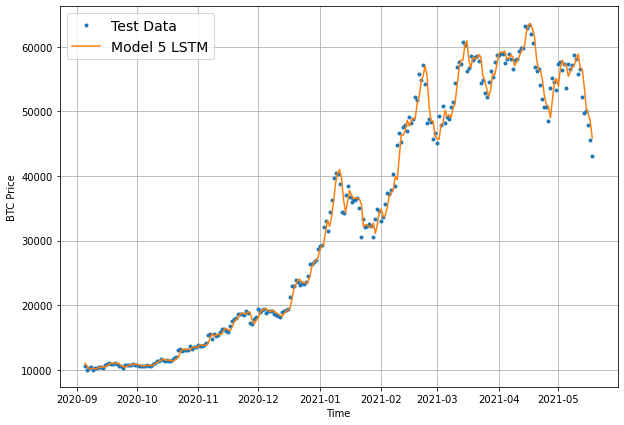

In [190]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows):], model_5_preds, start = offset, label = "Model 5 LSTM", format="-")

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not someone tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature we can use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [20]:
# Lets make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [21]:
# Lets add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (it starts from 1 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [22]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [23]:
# Add in a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [24]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [25]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


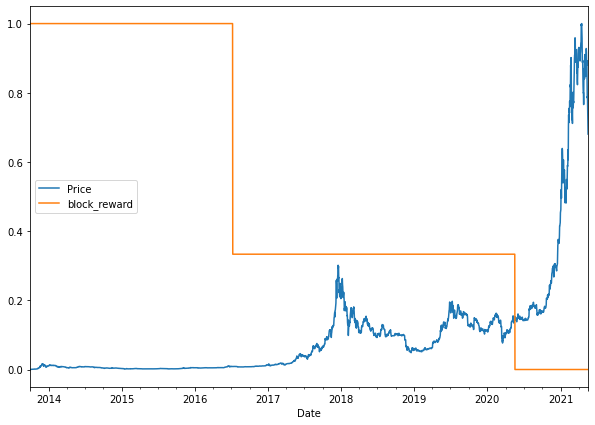

In [26]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), columns = bitcoin_prices_block.columns, index = bitcoin_prices_block.index);
scaled_price_block_df.plot(figsize = (10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univeriate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [27]:
# Setup dataset hyperparamters
HORIZON = 1
WINDOW_SIZE = 7

In [28]:
# Make a copy of the Bitcoin historical data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columsn
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods = i + 1)

bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


What we've done is created a way to window our dataset directly from a pandas dataframe

```
[0,1,2,3,4,5,6,block_reward] -> [7]
```

In [30]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [31]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [32]:
# Make train and test set using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [33]:
X_train.shape

(2224, 8)

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128).prefetch(tf.data.AUTOTUNE)

## Model 6: Dense Model

In [44]:
tf.random.set_seed(42)

# Create the model
inputs = tf.keras.layers.Input(shape = (WINDOW_SIZE + 1,), name = "input_layer")
x = tf.keras.layers.Dense(128, activation = "relu", name = "hidden_layer_1")(inputs)
x = tf.keras.layers.Dense(128, activation = "relu", name = "hidden_layer_2")(x)
outputs = tf.keras.layers.Dense(HORIZON, activation = "linear", name = "output_layer")(x)

model_6 = tf.keras.Model(inputs, outputs, name = "model_6_multivariate")

# Compile the model
model_6.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_6 = model_6.fit(
    train_dataset,
    epochs = 100,
    steps_per_epoch = len(train_dataset),
    validation_data = test_dataset,
    validation_steps = len(test_dataset),
    verbose = 0,
    callbacks = [create_model_checkpoint(model_6.name)]
)

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_6_multivariate\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_6_multivariate\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_6_multivariate\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_6_multivariate\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_6_multivariate\assets


In [45]:
model_6.evaluate(test_dataset)

5/5 [==============================] - 0s 5ms/step - loss: 744.0920 - mae: 744.0920 - mse: 1813502.1250


[744.0919799804688, 744.0919799804688, 1813502.125]

In [46]:
model_6 = tf.keras.models.load_model('Checkpoint/Time_Series/model_6_multivariate')
model_6.evaluate(test_dataset)

5/5 [==============================] - 0s 5ms/step - loss: 645.5536 - mae: 645.5536 - mse: 1391083.7500


[645.5536499023438, 645.5536499023438, 1391083.75]

In [47]:
model_6_preds = make_preds(model_6, X_test)
model_6_results = evaluate_preds(tf.squeeze(y_test), model_6_preds)
model_6_results

18/18 [==============================] - 0s 3ms/step


{'mae': 645.55365,
 'mse': 1391083.8,
 'rmse': 1179.4421,
 'mape': 2.894402,
 'mase': 1.0}

## Model 7: N-Beats algorithm

Lets try to build the biggest time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in the following paper: https://arxiv.org/pdf/1905.10437.pdf

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem.

### Building and testing the N-Beats block layer

Because the N-Beats block layer doesn't exist in TensorFlow we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [28]:
## Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers. Each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation = "relu") for _ in range(n_layers)]

        # Output of block is a theta layer with linear activations
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation = "linear", name = "theta")

    def call(self, inputs): # the call method is what runs when the layer is called
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)

        # Output the backcast and the forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Lets test our NBearsBlock class.

To do this we'll make some dummy inputs and output the results from the class object.

In [59]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_n_beats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,  theta_size = WINDOW_SIZE + HORIZON, horizon = HORIZON, n_neurons = 512, n_layers = 4)

In [60]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis = 0) # input shape to the model has to reflect dense layer input requirements (ndim = 2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [61]:
# Pass dummy inputs to the dummy n beats block layer
backcast, forecast = dummy_n_beats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (random because no training)
print(f'Backcast: {tf.squeeze(backcast.numpy())}')
print(f'Forecast: {tf.squeeze(forecast.numpy())}')

Backcast: [-0.02170164 -0.22593005  0.05997659 -0.01161927 -0.03913492 -0.02607802
 -0.16070884]
Forecast: 0.1074870228767395


### Preparing data for the N-Beats algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide:
https://www.tensorflow.org/guide/data_performance

In [29]:
HORIZON = 1
WINDOW_SIZE = 7

# Create NBEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [30]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f'Price{i+1}'] = bitcoin_prices_nbeats["Price"].shift(periods = i + 1)

bitcoin_prices_nbeats

,Price,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2013-10-01,123.654990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [31]:
X = bitcoin_prices_nbeats.dropna().drop('Price', axis = 1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [32]:
# Time to make our dataset performance using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [66]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for the residual stacking

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: ResNet Paper

In [70]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = tf.keras.layers.Subtract()([tensor_1, tensor_2])

# Add
added = tf.keras.layers.Add()([tensor_1, tensor_2])
subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])>)

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of an N-BEATS block layer (this will be the initial block used for the network and the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use the for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blcoks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of the NBEATS paper
9. Fit the N-BEATS model for 5000 epochs and since its fitting for so many epochs, we'll be using a couple of callbacks:
    * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
    * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [72]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name = "InitialBlock"
)

# 2. Create input to stack
stack_input = tf.keras.layers.Input(shape = (INPUT_SIZE), name = "stack_input")

# 3. Create initial backcast and forecast input (backwards prediction and forwards prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layer
for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already created in (3)
    # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
    backcast, block_forecast = NBeatsBlock(
        input_size = INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon = HORIZON,
        n_neurons = N_NEURONS,
        n_layers = N_LAYERS,
        name = f"NBeatsBlock_{i}"
    )(residuals)

    # 6. Create the double residual stacking
    residuals = tf.keras.layers.Subtract(name = f"subtract_{i}")([residuals, backcast])
    forecast = tf.keras.layers.Add(name = f'add_{i}')([forecast, block_forecast])

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs = stack_input, outputs = forecast, name = "model_7_nbeats")

# 8. Compile the model MAE loss
model_7.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

# 9. Fit the model with EarlyStopping and reduceLR on Plateau callbacks
history_model_7 = model_7.fit(
    train_dataset,
    epochs = N_EPOCHS,
    validation_data = test_dataset,
    verbose = 0,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 200, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 100, verbose = 1)]
)



Epoch 738: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 838: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: total: 7min 1s
Wall time: 6min 51s


In [73]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 300ms/step - loss: 574.1335


574.133544921875

In [74]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8890.643 , 8796.0625, 9022.6875, 8805.513 , 8765.212 , 8749.511 ,
       8692.421 , 8534.414 , 8483.971 , 8527.103 ], dtype=float32)>

In [76]:
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

{'mae': 574.13354,
 'mse': 1189949.4,
 'rmse': 1090.848,
 'mape': 2.5953434,
 'mase': 1.0}

### Plotting the N-BEATS architecture we've created

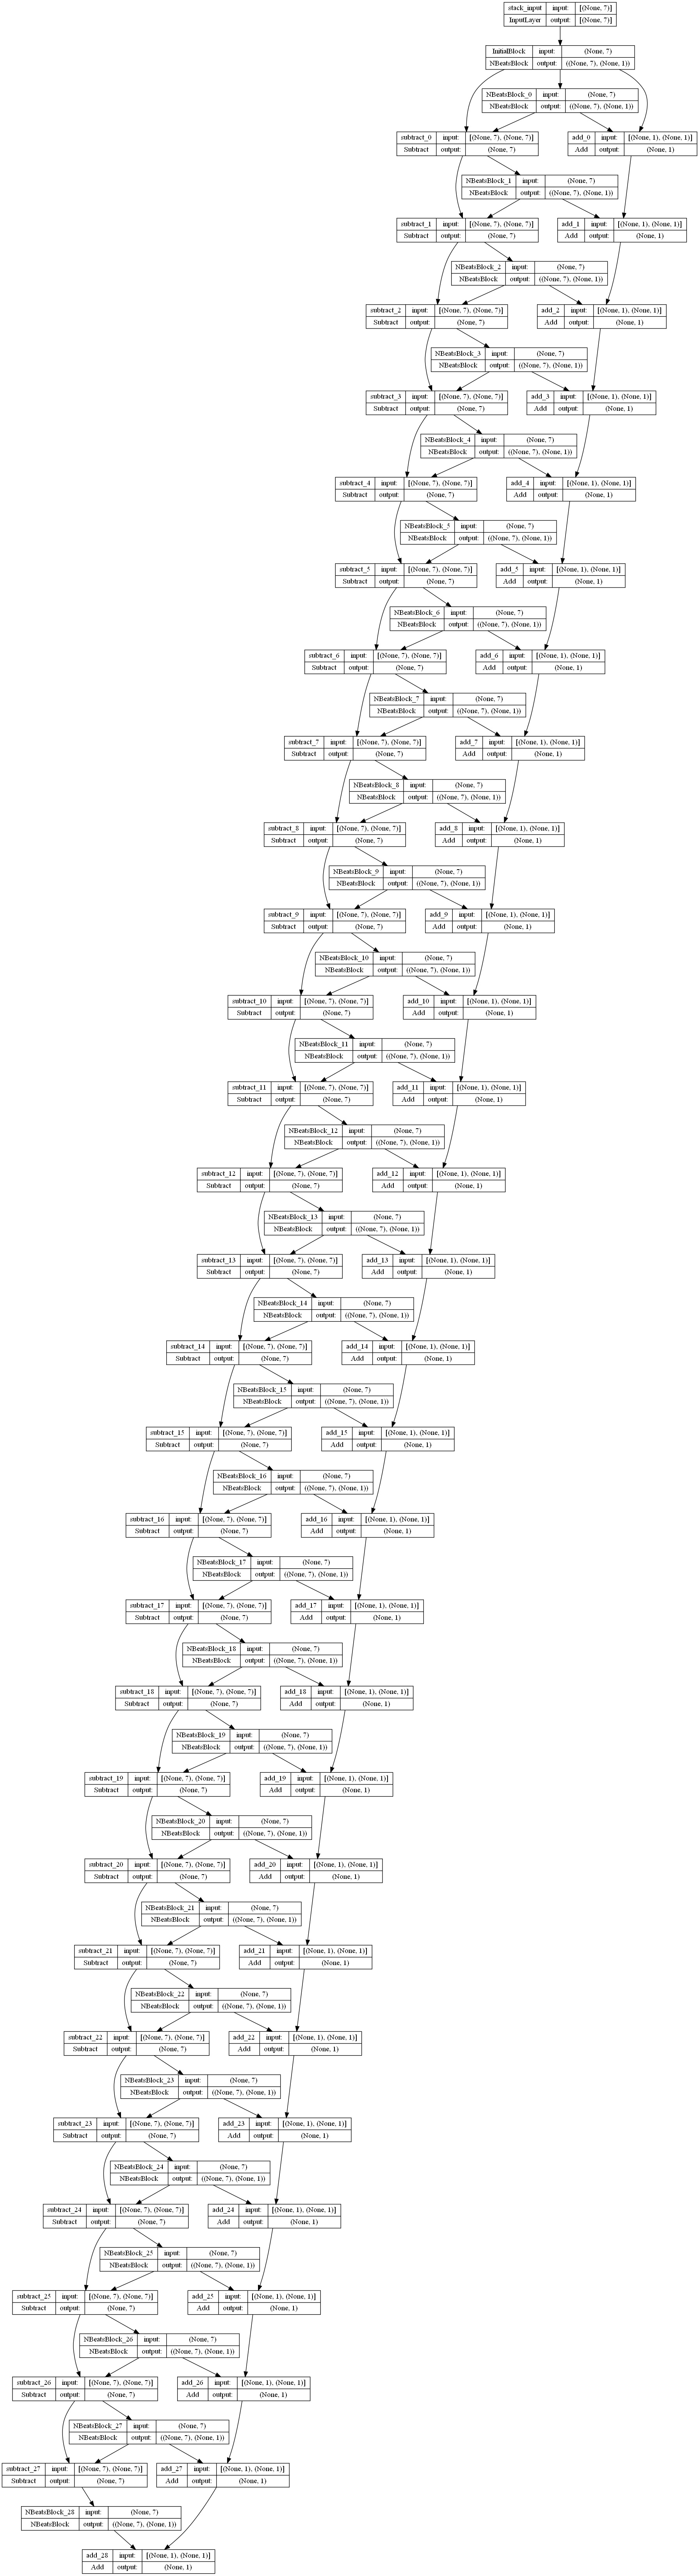

In [75]:
from tensorflow.keras.utils import plot_model

plot_model(model_7, show_shapes = True)

Whoa. Even with all those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as model_1 or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

## Model 8: Creating an ensemble (stacking different architectures together)

An ensemble leverages the wisdom of the crowd effect

It combines many different models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [34]:
def get_ensemble_models(horizon = HORIZON, train_data = train_dataset, test_data = test_dataset, num_iter = 10, num_epochs = 1000, loss_fns = ["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
    For example, if num_iter = 10, a list of 30 trained models will be returned (10 * len(["mae", "mse","mape"]))
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        for loss_function in loss_fns:
            print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')
            
            # Construct a simple model (similar to model_1)
            model = tf.keras.Sequential(
                [
                    # Initialize dense layers with normal distribution for estimating prediction intervals later on
                    tf.keras.layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
                    tf.keras.layers.Dense(128, kernel_initializer = "he_normal", activation = "relu"),
                    tf.keras.layers.Dense(HORIZON)
                ]
            )

            # Compile simple model with current loss function
            model.compile(
                loss = loss_function,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["mae", "mse"]
            )

            # Fit the current model
            model.fit(
                train_data,
                epochs = num_epochs,
                verbose = 0,
                validation_data = test_data,
                callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 100, verbose = 1)]
            )

            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
    return ensemble_models

In [35]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter = 5, num_epochs = 1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 779: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 879: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 270: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 370: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 265: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 853: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 699: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 315: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 415: ReduceLROnPl

In [36]:
len(ensemble_models)

15

## Make predictions with our ensemble model

In [41]:
# Create a function which uses a list of trained models to amek and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [42]:
%%time

# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, data = test_dataset)
ensemble_preds

1/1 [==============================] - 0s 39ms/step
CPU times: total: 1 s
Wall time: 881 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8793.033 ,  8767.295 ,  9102.877 , ..., 50125.48  , 48109.598 ,
        45843.49  ],
       [ 8756.015 ,  8778.405 ,  9020.241 , ..., 50087.617 , 48421.35  ,
        46000.15  ],
       [ 8804.693 ,  8802.996 ,  9055.728 , ..., 50206.117 , 48168.48  ,
        45794.535 ],
       ...,
       [ 8785.546 ,  8758.6875,  9111.071 , ..., 49266.81  , 47746.64  ,
        46490.156 ],
       [ 8826.804 ,  8751.461 ,  9079.872 , ..., 49536.254 , 48598.617 ,
        45297.594 ],
       [ 8804.79  ,  8783.121 ,  9056.391 , ..., 50047.21  , 48410.258 ,
        45772.723 ]], dtype=float32)>

In [43]:
ensemble_median = np.median(ensemble_preds, axis = 0)
ensemble_median[:10]

array([8796.445, 8783.121, 9064.93 , 8741.287, 8754.244, 8733.177,
       8656.255, 8485.197, 8463.716, 8519.212], dtype=float32)

In [44]:
ensemble_results = evaluate_preds(y_test, ensemble_median)
ensemble_results

{'mae': 568.2173,
 'mse': 1148942.6,
 'rmse': 1071.8873,
 'mape': 2.5748768,
 'mase': 0.9982066}